### Learning trajectory analysis 

##### Look at time trends and analyze various metrics of perforamance and strategy based evaluation methods 

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from IPython.display import display, HTML

In [162]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_session/filtered_data_101724.csv'
df = pd.read_csv(folder)

/tmp/ipykernel_7357/670866133.py:3: DtypeWarning: Columns (6,7,8,26,27,28,29,30,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder)


In [ ]:
# Check dimensions and content of dataframe for variables of interest: 

ids = df['subject_id'].unique()
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']
forag_eff_count = df['foraging_eff']
session_date_count = df['session_date'].unique()
task_count = df['task'].unique()
session_count = df['session'].unique()

print(f'Maximum number of sessions for any given subject: {len(session_count)}')
print(f'\nTypes of tasks: {task_count}, \n Number of unique tasks: {len(task_count)}')
print(f'\n Number of subjects: {len(ids)}')
print(f'\n Types of stages: {num_stage}, \n Number of total stages {len(stages)}')
print(f'\n Number of assigned dates {len(session_date_count)}')
print(f'\n Number of forag efficiency scores: {len(forag_eff_count)}')

#### Create dataframes

In [163]:
main_df = df[['subject_id', 'current_stage_actual','session', 'subject_genotype', 'foraging_eff', 'foraging_performance', 'foraging_eff_random_seed']]


main_task_df = df[['subject_id', 'current_stage_actual','session','task', 'subject_genotype', 'foraging_eff', 'foraging_performance', 'foraging_eff_random_seed']]

In [ ]:
main_df.head()

In [ ]:
main_task_df.head()

##### Cumulative analysis

In [164]:
sns.set_theme()

def analyze_session_distribution(df, task_col=None, bins=20, bins_task=40, y_max=0.4, y_max_task=0.5):
    """ 
    Create DataFrame showing the number of sessions per subject per stage and/or task
    with proper density-based distribution visualization
    
    Params: 

    df: DataFrame
        Foraging DataFrame with metric, stage features, task features
    task_col = optional for task DataFrame

    bins (task) = set number of bins for either DataFrame
    ymax (task) = set manual maximum y axis value, if None default will be used
        
    Returns: 
    tuple : (DataFrame, DataFrame)
        session_counts: Individual counts per subject
        summary_stats: Summary statistics of the distribution
    """
    # Group by subject and stage, and optionally task
    if task_col:
        session_counts = (df.groupby(['subject_id', 'current_stage_actual', task_col])
                         .agg({'session': 'count'})
                         .reset_index()
                         .rename(columns={'session': 'num_sessions'}))
    else:
        session_counts = (df.groupby(['subject_id', 'current_stage_actual'])
                         .agg({'session': 'count'})
                         .reset_index()
                         .rename(columns={'session': 'num_sessions'}))
    
    # Create density plots
    plt.figure(figsize=(12, 6))
    
    # Create distribution plot and proper normalization
    if task_col:
        g = sns.displot(data=session_counts, 
                    x='num_sessions',
                    col='current_stage_actual',
                    row=task_col,
                    kind='hist',
                    bins=bins_task,
                    height=4,
                    aspect=1.5,
                    stat='density',
                    common_norm=False)
        # Adjust y-axis limits for all subplots
        for ax in g.axes.flat:
            if y_max_task is not None:
                ax.set_ylim(0, y_max_task)
    else:
        g = sns.displot(data=session_counts, 
                    x='num_sessions',
                    col='current_stage_actual',
                    kind='hist',
                    bins=bins,
                    height=4,
                    aspect=1.5,
                    stat='density',
                    common_norm=False)
        # Adjust y-axis limits for all subplots
        for ax in g.axes.flat:
            if y_max is not None:
                ax.set_ylim(0, y_max)
        
    def safe_kde_plot(data, **kwargs):
        if len(data) > 1 and np.var(data) > 0:
            sns.kdeplot(data=data, warn_singular=False, **kwargs)
    
    g.map(safe_kde_plot, 'num_sessions', color='grey', linewidth=2)
    
    if task_col:
        plt.suptitle('Distribution of Session Counts by Stage and Task', y=1.02)
    else:
        plt.suptitle('Distribution of Session Counts by Stage', y=1.02)
    
    # Add more detailed statistics
    if task_col:
        summary_stats = (session_counts.groupby(['current_stage_actual', task_col])
                        .agg({
                            'num_sessions': ['count', 'mean', 'std', 'min', 'max', 
                                           lambda x: x.quantile(0.25),
                                           lambda x: x.quantile(0.75)]
                        })
                        .round(2))
    else:
        summary_stats = (session_counts.groupby('current_stage_actual')
                        .agg({
                            'num_sessions': ['count', 'mean', 'std', 'min', 'max',
                                           lambda x: x.quantile(0.25),
                                           lambda x: x.quantile(0.75)]
                        })
                        .round(2))
    
    summary_stats.columns = ['num_subjects', 'mean_sessions', 'std_sessions', 
                           'min_sessions', 'max_sessions', 'q25_sessions', 'q75_sessions']
    summary_stats = summary_stats.reset_index()
    
    return session_counts, summary_stats

In [ ]:
# Apply function to task and no task DataFrames

counts_main_task, task_stats = analyze_session_distribution(main_task_df, task_col='task')
print(task_stats)
counts_main, stats = analyze_session_distribution(main_df)
print(stats)

In [165]:

# Identify sub groups 

def split_by_session_threshold(df, session_counts, threshold=None, task_col=None):
    """ 
    Split DataFrame based on session count Threshold in STAGE_1

    Params:

    df: DataFrame containing all data
    session counts: DataFrame containing session counts per subject_id/stage/task
    threshold: int (optional) based off of prior session count visualization
    task_col: str (optional) for task DataFrame specification 

    Returns:

    tuple: (DataFrame, DataFrame, int): 
            slow_df: DataFrame with subjects above threshold
            fast_df: DataFrame with subjects below threshold
            threshold_value: threshold (int) used for splitting 
    """ 

    # Get Stage 1 counts
    stage1_counts = session_counts[
        session_counts['current_stage_actual'] == 'STAGE_1'
    ].copy()

    # For task DataFrame average across tasks for Stage 1
    if task_col:
        stage1_counts = (stage1_counts.groupby('subject_id')['num_sessions'].mean().reset_index())

    # Use median if no threshold is provided
    if threshold is None:
        threshold_value = stage1_counts['num_sessions'].median()
    else:
        threshold_value = threshold

    # Get subject_ids below and above threshold
    slow_subjects = stage1_counts[stage1_counts['num_sessions'] >= threshold_value]['subject_id'].unique()

    fast_subjects = stage1_counts[stage1_counts['num_sessions'] < threshold_value]['subject_id'].unique()

    # Split DataFrame
    slow_df = df[df['subject_id'].isin(slow_subjects)].copy()
    fast_df = df[df['subject_id'].isin(fast_subjects)].copy()

    # Summary stats
    print(f'Threshold value: {threshold_value:.2f} sessions')
    print(f'Number of slow learners {len(slow_subjects)}')
    print(f'Number of fast learners {len(fast_subjects)}')

    return slow_df, fast_df, threshold_value


In [ ]:
threshold_value = 2

result_main_tple = split_by_session_threshold(main_df, counts_main, threshold_value)

In [ ]:
result_task_main_tple = split_by_session_threshold(main_task_df, counts_main_task, threshold_value, task_col='task')

In [178]:
def analyze_splits(df, task_col=None, threshold=threshold_value, **kwargs):
    """
    Analyze session distributions for both slow and fast session count DataFrames

    params:

    df: DataFrame in original analyze_sessions function
    task_col: str (optional) for task-specific DataFrame
    threshold: int (optional) threshold for split calculation
    **kwargs: additional args

    Returns:
    tuple: (dict, dict): DataFrames and stats for slow and fast learners
    """ 

    # First get session counts
    session_counts, stats = analyze_session_distribution(df, task_col=task_col, **kwargs)
    
    # Split the data
    slow_df, fast_df, threshold_value = split_by_session_threshold(
        df, session_counts, threshold=threshold, task_col=task_col
    )
    
    # Analyze both splits
    slow_counts, slow_stats = analyze_session_distribution(slow_df, task_col=task_col, **kwargs)
    fast_counts, fast_stats = analyze_session_distribution(fast_df, task_col=task_col, **kwargs)
    
    return {
        'slow': {'df': slow_df, 'counts': slow_counts, 'stats': slow_stats},
        'fast': {'df': fast_df, 'counts': fast_counts, 'stats': fast_stats},
        'threshold': threshold_value
    }

Threshold value: 2.00 sessions
Number of slow learners 40
Number of fast learners 52


<Figure size 1200x600 with 0 Axes>

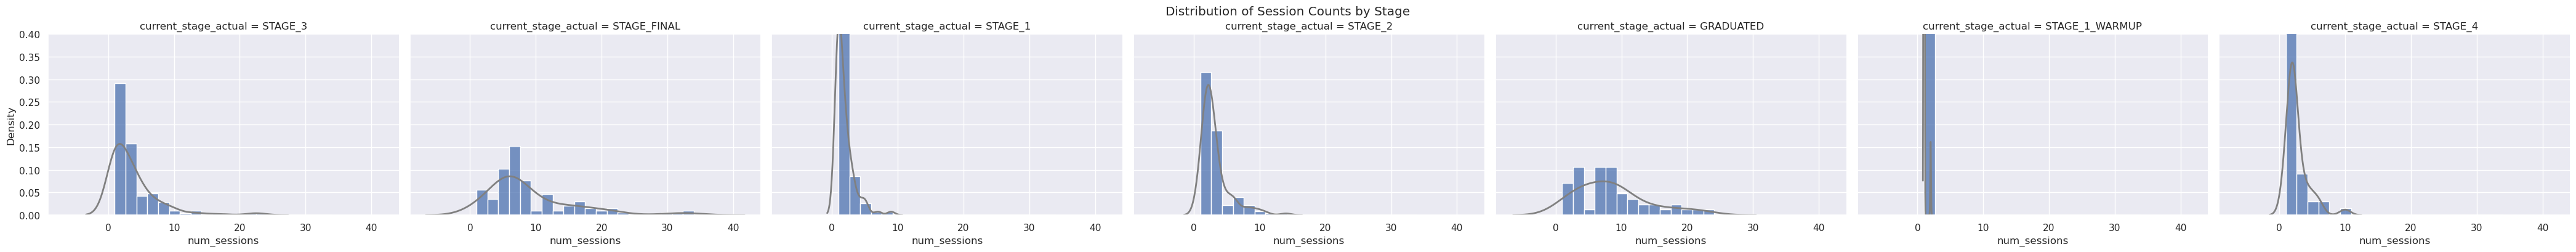

<Figure size 1200x600 with 0 Axes>

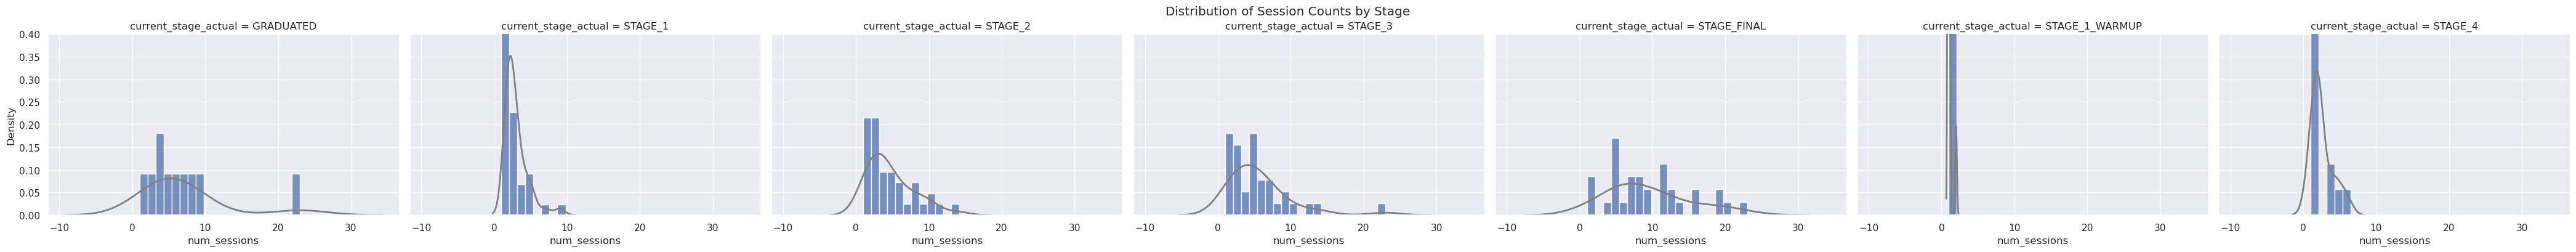

<Figure size 1200x600 with 0 Axes>

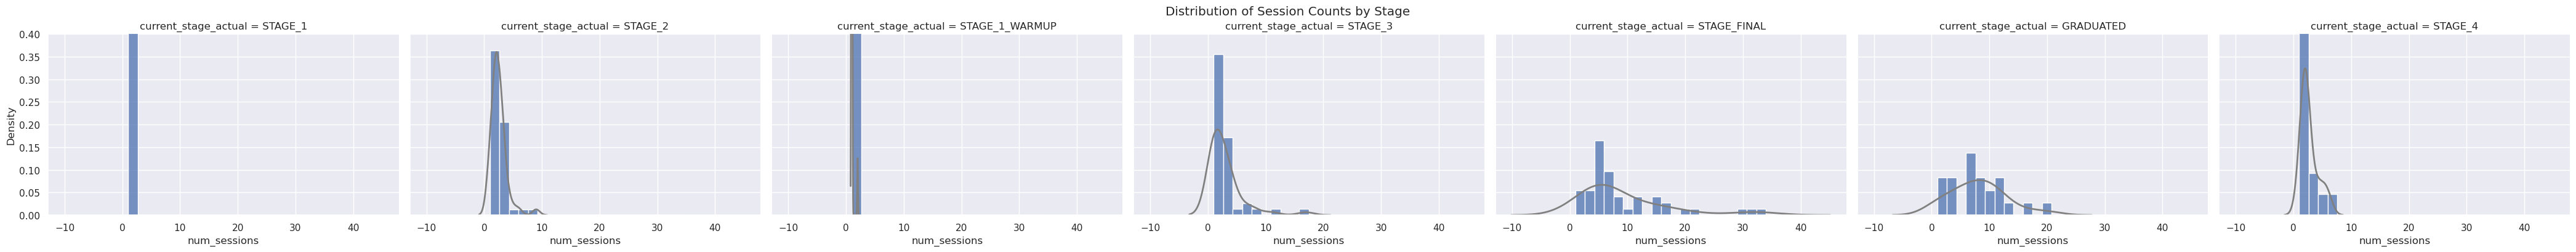

In [179]:
main_results = analyze_splits(main_df)

slow_session_main_df = main_results['slow']['df']
fast_session_main_df = main_results['fast']['df']
threshold_used = main_results['threshold']

Threshold value: 2.00 sessions
Number of slow learners 40
Number of fast learners 52


<Figure size 1200x600 with 0 Axes>

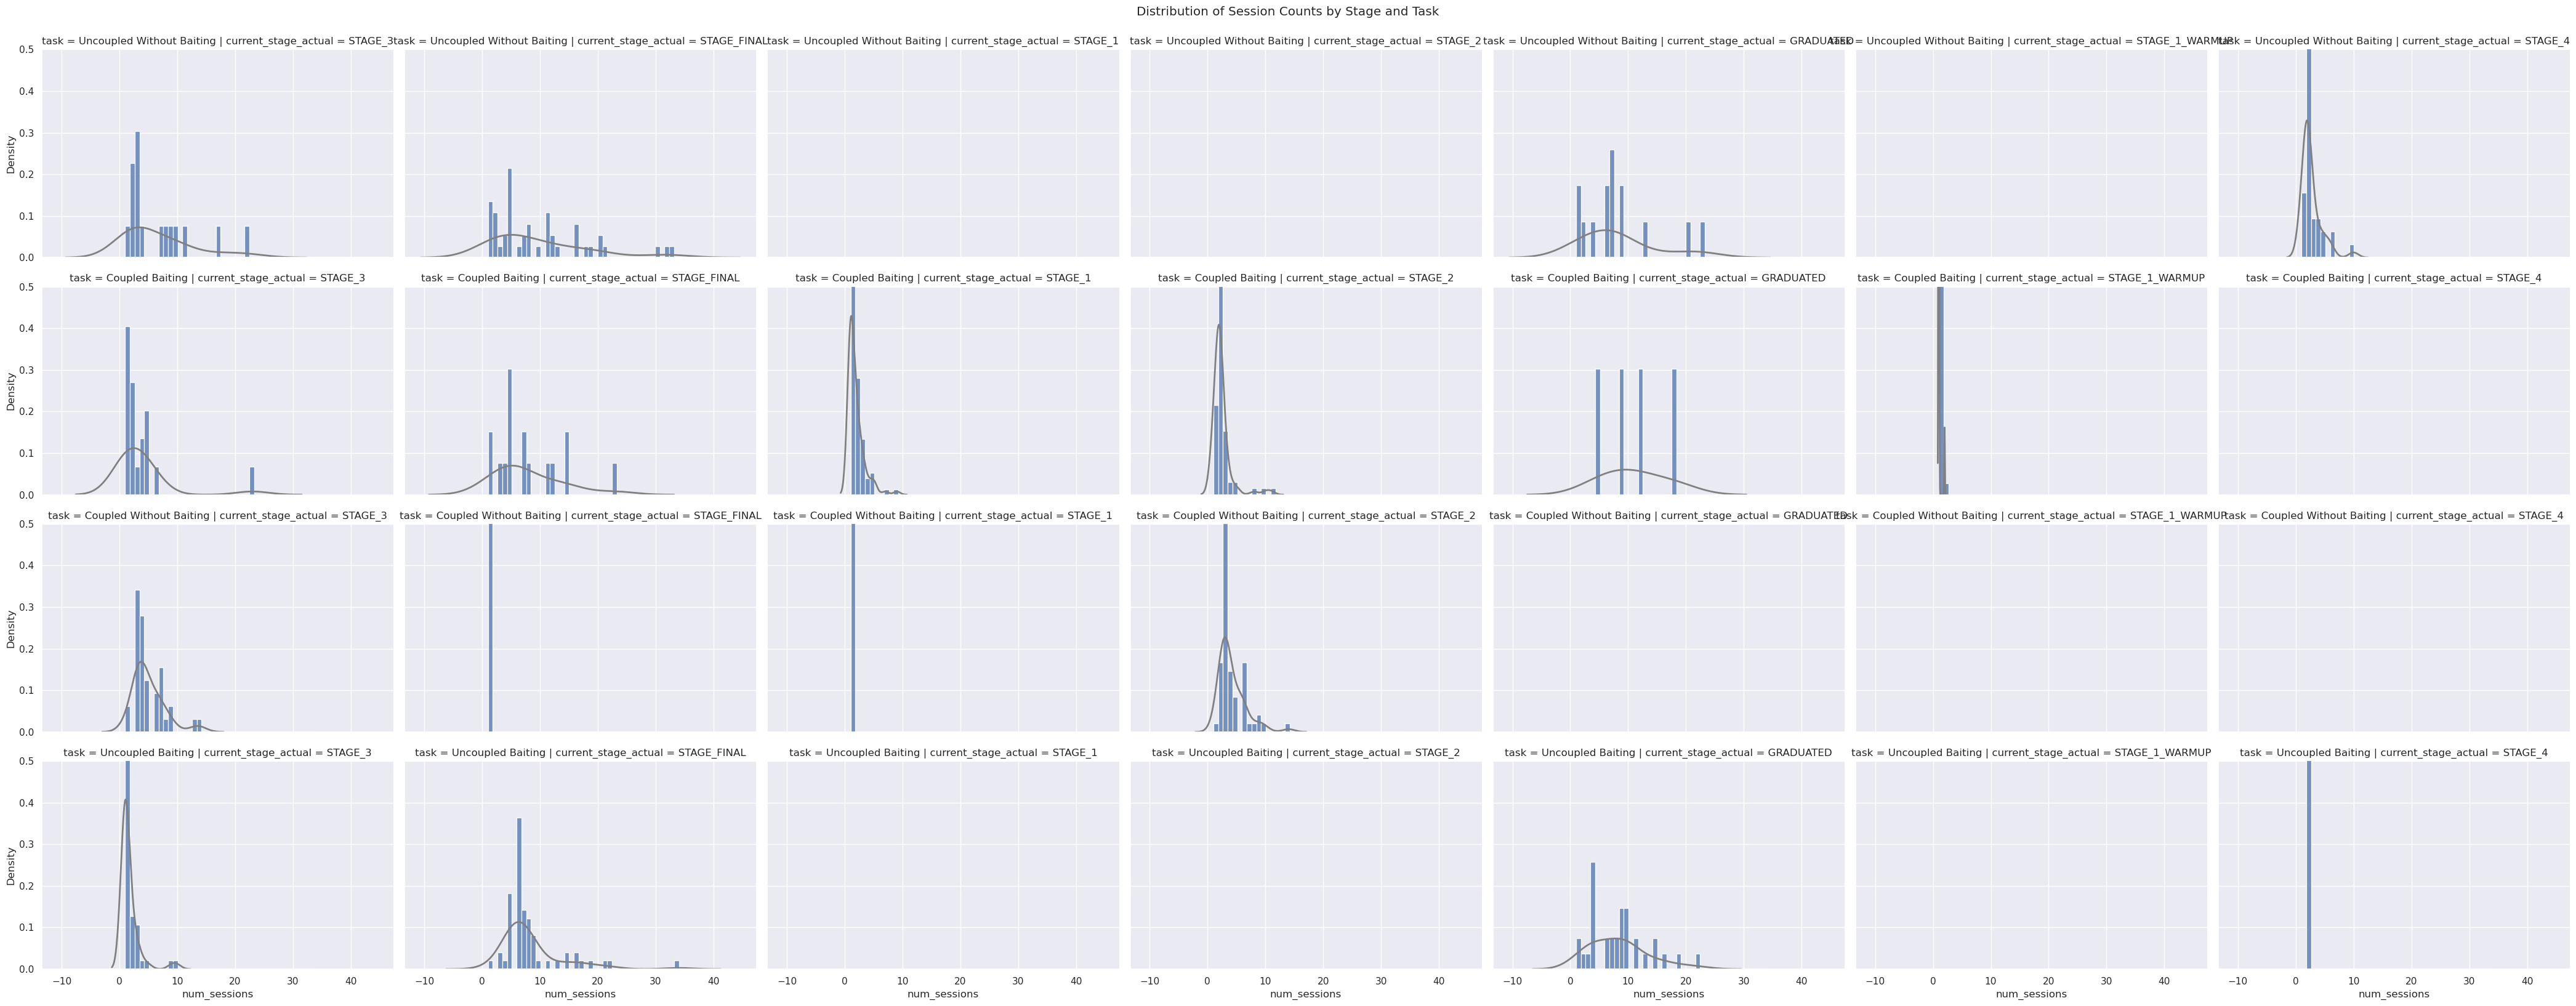

<Figure size 1200x600 with 0 Axes>

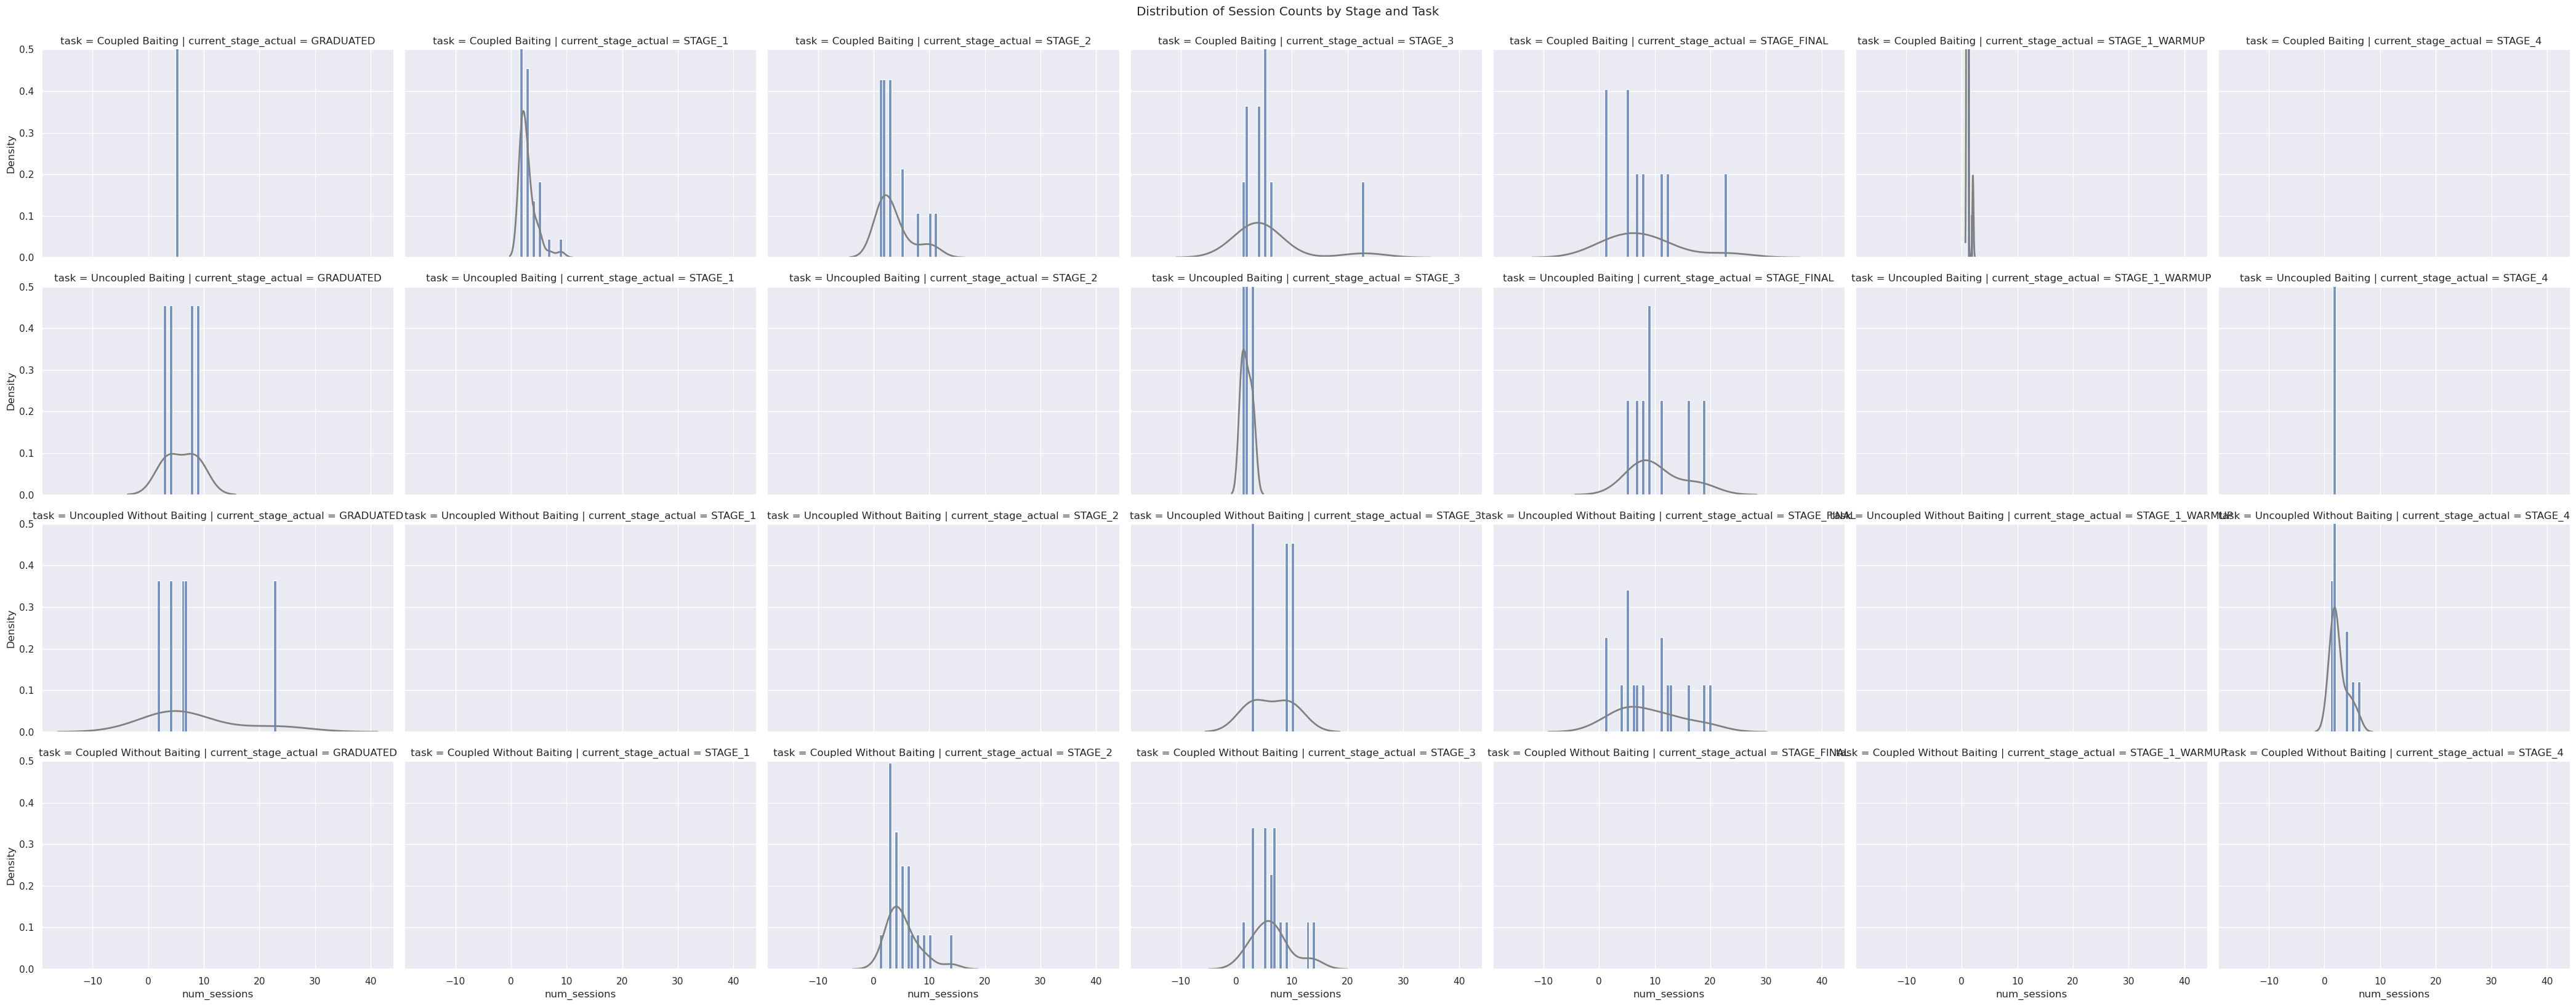

<Figure size 1200x600 with 0 Axes>

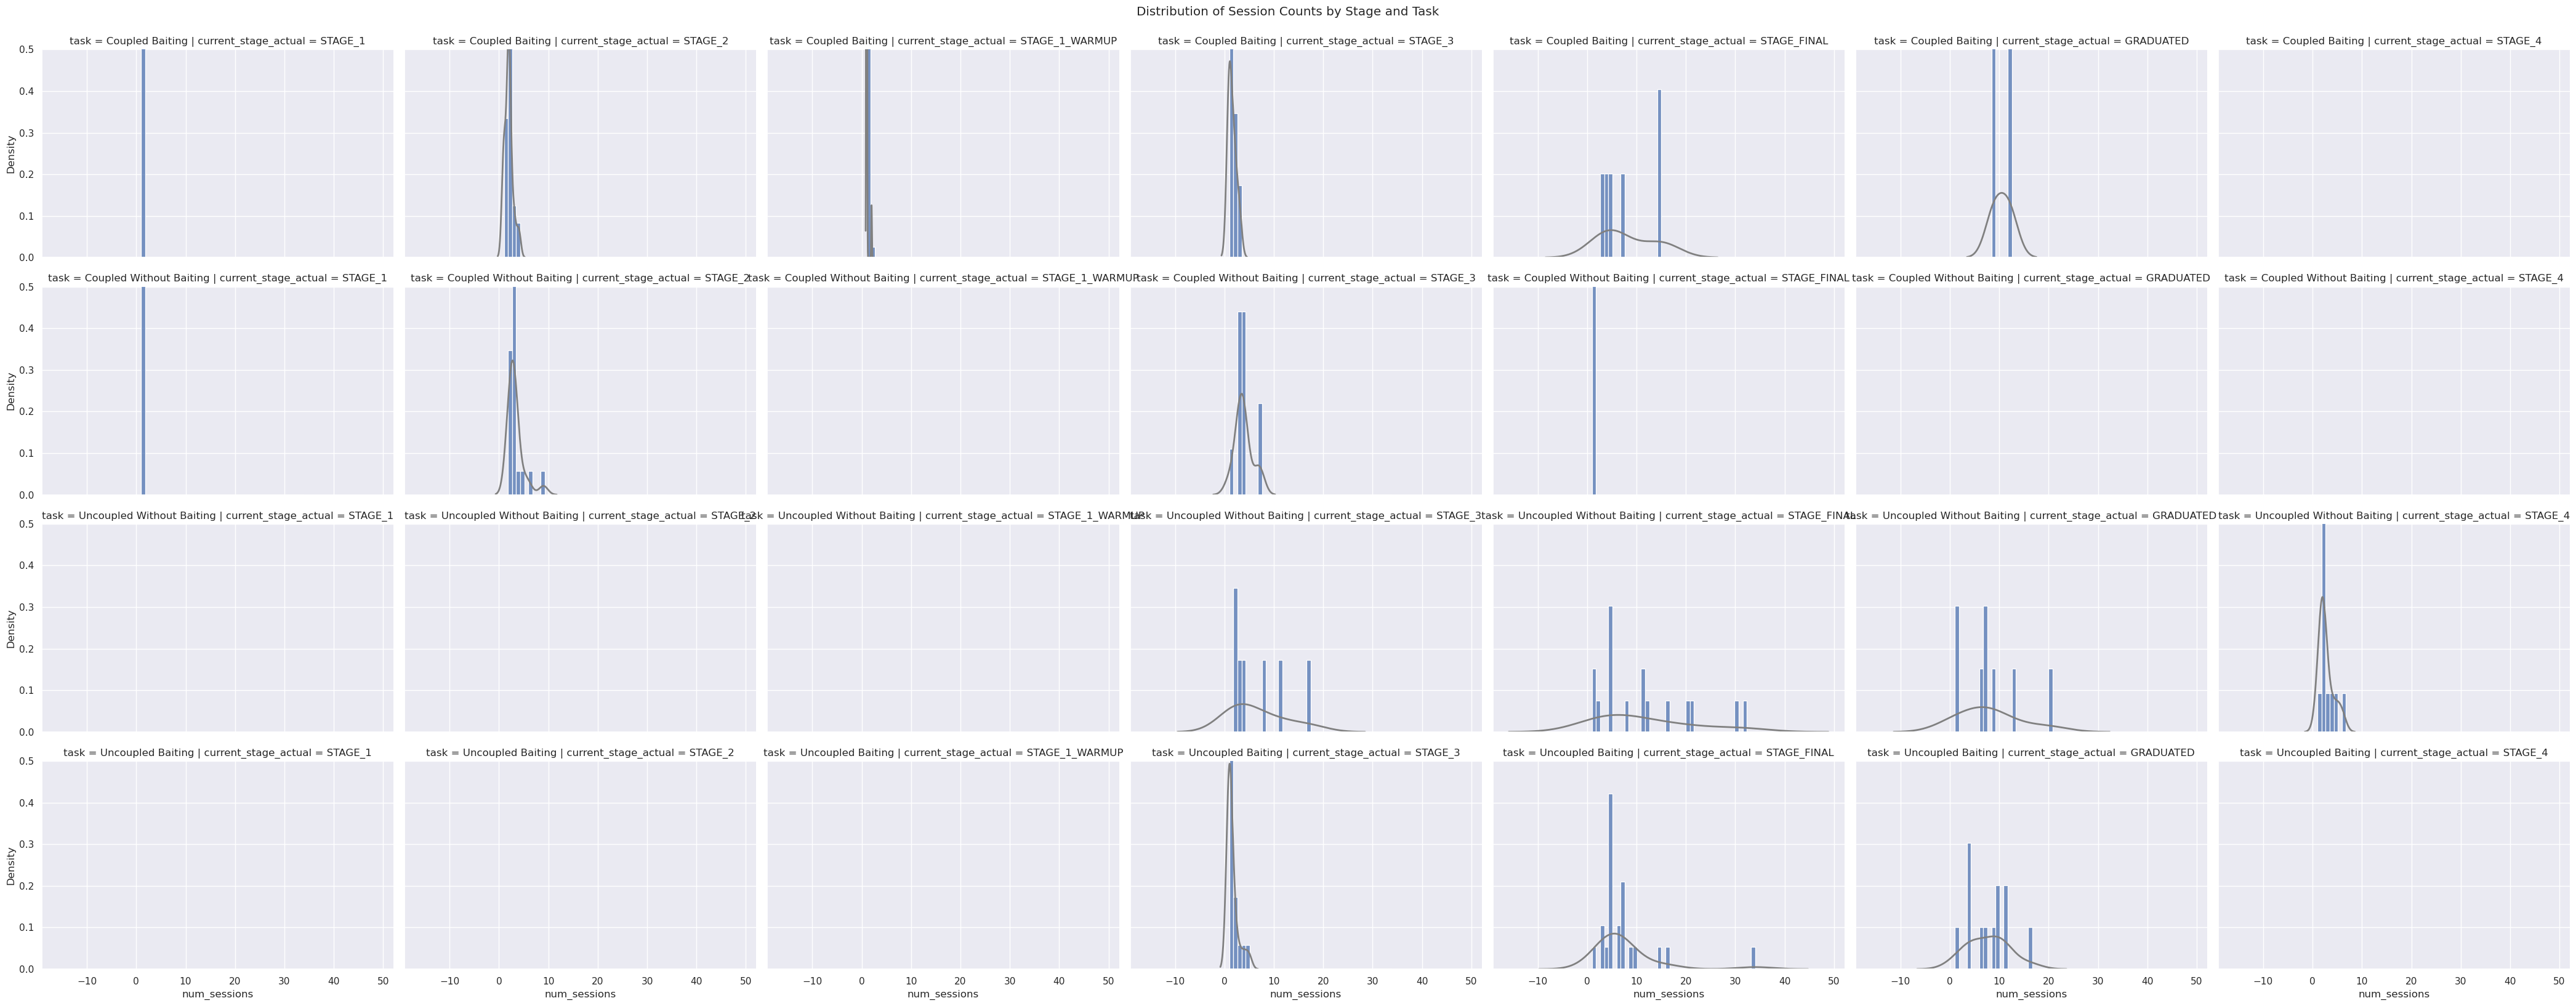

In [180]:
task_results = analyze_splits(main_task_df, task_col='task')

slow_session_task_df = task_results['slow']['df']
fast_session_task_df = task_results['fast']['df']

In [ ]:
# Create design matrices for all task types 

def create_stage_arrays(df, stage_col='current_stage_actual', subject_col='subject_id', metric='foraging_eff'):
    # Get unique stages and subjects

    stages = df[stage_col].unique()
    subjects = df[subject_col].unique()

    stage_arrays = {}

    for stage in stages:
        # Filter the dataframe for the current stage
        stage_df = df[df[stage_col] == stage]
        
        # Get the max number of sessions for this stage
        max_sessions = stage_df.groupby(subject_col).size().max()
        
        # For the NaN stage
        if pd.isna(max_sessions):
            print(f"No data found for stage {stage}")
            continue
        
        max_sessions = int(max_sessions)
        
        stage_array = np.full((len(subjects), max_sessions), np.nan)
        
        # Fill the array with foraging efficiency scores
        for i, subject in enumerate(subjects):
            subject_data = stage_df[stage_df[subject_col] == subject][metric].values
            stage_array[i, :len(subject_data)] = subject_data
        
        stage_arrays[stage] = stage_array

    return stage_arrays

In [ ]:
stage_arrays = create_stage_arrays(fe_df)
for stage, array in stage_arrays.items():
    print(f'Stage {stage}: Array shape: {array.shape}')

In [ ]:
fp_stage_arrays = create_stage_arrays(fp_df, metric='foraging_performance')
for stage, array in fp_stage_arrays.items():
    print(f'Stage {stage}: Array shape: {array.shape}')

In [ ]:
rs_stage_arrays = create_stage_arrays(rs_df, metric='foraging_eff_random_seed')
for stage, array in rs_stage_arrays.items():
    print(f'Stage {stage}: Array shape: {array.shape}')

In [ ]:
# Create design matrices for all task / stage combinations

# Get unique stages, subjects, and tasks
stages = fe_df['current_stage_actual'].unique()
subjects = fe_df['subject_id'].unique()
tasks = fe_df['task'].unique()

# Initialize new dictionary 
stage_task_arrays = {}

for stage in stages:
    for task in tasks:
        # Filter the dataframe for the current stage and task
        stage_task_df = fe_df[(fe_df['current_stage_actual'] == stage) & (fe_df['task'] == task)]
        
        max_sessions = stage_task_df.groupby('subject_id').size().max()
        
        # For stages or tasks with no data
        if pd.isna(max_sessions):
            print(f"No data found for stage {stage} and task {task}")
            continue
        
        max_sessions = int(max_sessions)
        
        stage_task_array = np.full((len(subjects), max_sessions), np.nan)
        
        # Fill the array with fe scores
        for i, subject in enumerate(subjects):
            subject_data = stage_task_df[stage_task_df['subject_id'] == subject]['foraging_eff'].values
            stage_task_array[i, :len(subject_data)] = subject_data
        
        stage_task_arrays[(stage, task)] = stage_task_array

for (stage, task), array in stage_task_arrays.items():
    print(f"Stage {stage}, Task {task}: Array shape = {array.shape}")

In [ ]:
# Create readable table of above data for task, stage, fe counts

count_data = []

for stage in stages:
    for task in tasks:
        # Filter the df for the current stage and task
        stage_task_df = fe_df[(fe_df['current_stage_actual'] == stage) & (fe_df['task'] == task)]
        
        # Count the number of scores for this stage and task
        count = stage_task_df['foraging_eff'].count()
        
        # Append the count to list
        count_data.append({
            'Stage': stage,
            'Task': task,
            'Count': count
        })

# Create the df from the list of count data
count_df = pd.DataFrame(count_data)

# Pivot the df to create a table with stages as rows and tasks as columns
result_table = count_df.pivot(index='Stage', columns='Task', values='Count')

result_table = result_table.fillna(0).astype(int)

# Add the total for both rows and columns
result_table.loc['Total'] = result_table.sum()
result_table['Total'] = result_table.sum(axis=1)

print(result_table)

In [ ]:
# Function to adjust outliers in each stage 

def remove_outliers_n(data_dict, n):
    result = {}

    for key, array in data_dict.items():

        if isinstance(key, tuple):
            stage, task = key
        else:
            stage = key
            task = None

        # Count num of fe values in each row
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        # Sort rows by their fe counts
        sorted_indices = np.argsort(non_nan_counts)[::-1]
        sorted_counts = non_nan_counts[sorted_indices]
        
        # Find the cutoff point
        if len(sorted_counts) > n:
            cutoff = sorted_counts[n]
        else:
            cutoff = sorted_counts[-1]
        
        # Create a mask for rows to keep
        keep_mask = non_nan_counts <= cutoff
        
        # Create make for rows to trim
        trim_mask = non_nan_counts > cutoff
        
        new_array = np.full((array.shape[0], cutoff), np.nan)
        
        # Fill in the rows that are kept
        new_array[keep_mask] = array[keep_mask][:, :cutoff]
        
        # Fill in the trimmed rows
        for i in np.where(trim_mask)[0]:
            non_nan_indices = np.where(~np.isnan(array[i]))[0][:cutoff]
            new_array[i, :len(non_nan_indices)] = array[i, non_nan_indices]
        
        if task is not None:
            result[(stage, task)] = new_array
        else:
            result[stage] = new_array
    
    return result


In [ ]:
# Set prefrence for outlier removal 

n = 4
n1 = 1
n2 = 2

# Non-task specific dict
filtered_arrays = remove_outliers_n(stage_arrays, n)

# Task specific dict
filtered_stage_task_arrays = remove_outliers_n(stage_task_arrays, n1)

#Non-task foraging performance dict
filtered_fp_arrays = remove_outliers_n(fp_stage_arrays, n2)

# random seed dict
filtered_rs_arrays = remove_outliers_n(rs_stage_arrays, n1)

In [ ]:
# Count fe values for each subject after adjustment
plt.rcParams['image.cmap'] = 'viridis'
plt.figure(figsize=(20, 6))

sns.set_theme()

for stage, array in filtered_arrays.items():
    non_nan_counts = np.sum(~np.isnan(array), axis=1)
    sns.histplot(non_nan_counts, kde=True, label=stage)

plt.title('Distribution of Number of FE Scores per Subject for All Stages')
plt.xlabel('Number of FE Scores')
plt.ylabel('Count of Subjects')
plt.xlim(left=0)
plt.legend()
plt.show()

In [ ]:
# Summarize distribution of number of fe scores per stage

def summary_statistics(data_dict):
    summary_data = []

    for key, array in data_dict.items():
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        Q1 = np.percentile(non_nan_counts, 5)
        Q3 = np.percentile(non_nan_counts, 95)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        outliers = non_nan_counts[(non_nan_counts > upper_bound)]
        
        if isinstance(key, tuple):
            stage, task = key
        else:
            stage, task = key, "N/A"

        summary_data.append({
            'Stage': stage,
            'Task': task,
            'Array Shape': array.shape,
            'Mean': np.mean(non_nan_counts),
            'Std Dev': np.std(non_nan_counts),
            'Min': np.min(non_nan_counts),
            'Max': np.max(non_nan_counts),
            'Outliers': len(outliers)
        })

    # Create a summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    return summary_df


In [ ]:
# Summary for stage only dataset 

summary_statistics(filtered_arrays)

In [ ]:
# Summary for stage/task dataset 

summary_statistics(filtered_stage_task_arrays)

In [ ]:
# Create heatmap for visualization of an example array in stage only dictionary 

def plot_array_heatmap(array, stage):
    plt.figure(figsize=(16,5))
    plt.imshow(array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Foraging Efficiency')
    plt.title(f'Foraging Efficiency Heatmap for {stage}')
    plt.xlabel('Session Index')
    plt.ylabel('Subject Index')
    plt.show()

In [ ]:
plot_array_heatmap(filtered_arrays['STAGE_3'], 'STAGE_3')

In [ ]:
def calculate_average_vectors(data_dict):
    averages = {}

    if isinstance(next(iter(data_dict.keys())), tuple):
        # Stage task dictionary
        for (stage, task), array in data_dict.items():
            if stage not in averages:
                averages[stage] = {}
            averages[stage][task] = np.nanmean(array, axis=0)
    else:
        # Stage dictionary
        for stage, array in data_dict.items():
            averages[stage] = np.nanmean(array, axis=0)

    # Find the average vectors
    for stage, value in averages.items():
        print(f"\nAverage foraging efficiency for stage {stage}:")
        if isinstance(value, dict):
            for task, average_vector in value.items():
                print(f" \n Task: {task}")
                print(f" \n Average vector: {average_vector}")
                print(f" \n Shape: {average_vector.shape}")
        else:
            print(f"Average vector: {value}")
            print(f"Shape: {value.shape}")

    return averages

In [ ]:
stage_averages = calculate_average_vectors(filtered_arrays)
stage_task_averages = calculate_average_vectors(stage_task_arrays)

In [ ]:
# Plot function for foraging efficiency over stages 


def plot_foraging_efficiency(data_dict, stage_sequence, ylabel='Foraging Efficiency'):
    is_stage_task = isinstance(next(iter(data_dict.keys())), tuple)
    
    # Choose between task/stage dictionary and stage dictionary 
    if is_stage_task:
        tasks = list(set(task for _, task in data_dict.keys()))
    else:
        tasks = ['']
    
    for task in tasks:
        data = []
        subject_data = []
        overall_session = 0

        for stage in stage_sequence:
            if is_stage_task:
                if (stage, task) in data_dict:
                    stage_data = data_dict[(stage, task)]
                else:
                    continue
            else:
                if stage in data_dict:
                    stage_data = data_dict[stage]
                else:
                    continue

            num_sessions = stage_data.shape[1]
            num_subjects = stage_data.shape[0]
            
            for session in range(num_sessions):
                session_data = stage_data[:, session]
                mean = np.nanmean(session_data)
                std = np.nanstd(session_data)
                
                data.append({
                    'Stage': stage,
                    'Session': overall_session,
                    'Stage Session': session,
                    'Mean': mean,
                    'Std': std
                })
                
                for subject in range(num_subjects):
                    subject_data.append({
                        'Stage': stage,
                        'Session': overall_session,
                        'Stage Session': session,
                        'Subject': subject,
                        'Score': stage_data[subject, session]
                    })

                overall_session += 1

        stage_plot_df = pd.DataFrame(data)
        subject_plot_df = pd.DataFrame(subject_data)

        plt.figure(figsize=(20, 6))

        sns.scatterplot(x='Session', y='Score', data=subject_plot_df, alpha=0.2, color='grey', legend=False)
        sns.lineplot(x='Session', y='Mean', data=stage_plot_df)


        plt.fill_between(stage_plot_df['Session'], 
                        stage_plot_df['Mean'] - stage_plot_df['Std'], 
                        stage_plot_df['Mean'] + stage_plot_df['Std'], 
                        alpha=0.2, color='b')

        plt.xlabel('Session (across all stages)', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)

        stage_boundaries = [stage_plot_df[stage_plot_df['Stage'] == stage]['Session'].min() 
                            for stage in stage_sequence if stage in stage_plot_df['Stage'].unique()]
        for boundary in stage_boundaries[1:]:
            plt.axvline(x=boundary - 0.5, color='b', linestyle='--', alpha=0.5)

        xticks = []
        xticklabels = []
        for i, stage in enumerate(stage_sequence):
            if stage in stage_plot_df['Stage'].unique():
                stage_sessions = stage_plot_df[stage_plot_df['Stage'] == stage]['Session']
                stage_start = stage_sessions.min()
                stage_end = stage_sessions.max()
                stage_ticks = range(int(stage_start), int(stage_end) + 1, 4)
                xticks.extend(stage_ticks)
                xticklabels.extend(range(0, (len(stage_ticks) - 1) * 4 + 1, 4))

                mid_point = (stage_start + stage_end) / 2
                plt.text(mid_point, plt.ylim()[1], stage, horizontalalignment='center', verticalalignment='bottom')

        plt.xticks(xticks, xticklabels)
        plt.xticks(ha='right')

        plt.plot([], [], color='grey', alpha=0.2, linewidth=0, marker='o', markersize=10, label='Subject Scores')

        if is_stage_task:
            plt.plot([], [], color='blue', linewidth=2, label=f'{task} Mean Score')
        else:
            plt.plot([], [], color='blue', linewidth=2, label='All Task Mean Score')
        
        plt.fill_between([], [], alpha=0.2, label='Standard Deviation')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"\nStatistics for {'Task: ' + task if is_stage_task else 'All Tasks'}:")
        for stage in stage_sequence:
            if stage in stage_plot_df['Stage'].unique():
                stage_data = stage_plot_df[stage_plot_df['Stage'] == stage]
                print(f'\n{stage}:')
                print(f'Number of Sessions: {len(stage_data)}')
                print(f"Mean {ylabel}: {stage_data['Mean'].mean():.2f}")
                print(f"Standard deviation: {stage_data['Mean'].std():.2f}")
                print(f"Min efficiency: {stage_data['Mean'].min():.2f}")
                print(f"Max efficiency: {stage_data['Mean'].max():.2f}")

In [ ]:
stage_sequence = ['STAGE_1_WARMUP', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

# Stage Foraging Efficiency 
plot_foraging_efficiency(filtered_arrays, stage_sequence)

# Stage Task Foraging Efficiency 
plot_foraging_efficiency(filtered_stage_task_arrays, stage_sequence)

# Foraging Performance
plot_foraging_efficiency(filtered_fp_arrays, stage_sequence, ylabel='Foraging Performance')

# Random Seed
plot_foraging_efficiency(filtered_rs_arrays, stage_sequence, ylabel='Foraging Efficiency Random Seed')

In [ ]:
# Genotype plots

# Group by genotype and week
geno_df['session_date'] = pd.to_datetime(df['session_date'], errors='coerce')
geno_df['week'] = geno_df['session_date'].dt.to_period('W')
grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].agg(['mean', 'std']).reset_index() # Calculate mean foraging efficiency 
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()


# Take only top 5 most common genotypes in df
top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


# Plot dataframe
plt.figure(figsize=(20, 6))

# Plot average foraging efficiency for each genotype 
for genotype in grouped_df['subject_genotype'].unique():
    data = grouped_df[grouped_df['subject_genotype'] == genotype]
    plt.errorbar(data['week'], data['mean'], yerr=data['std'], label=genotype, capsize=3, capthick=3)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon = False)

plt.tight_layout()
plt.show()

In [ ]:
# Rolling average plot 

grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].mean().reset_index()
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()

# Use 3 week rolling average
grouped_df = grouped_df.sort_values(['subject_genotype', 'week'])
grouped_df['rolling_avg'] = grouped_df.groupby('subject_genotype')['foraging_eff'].rolling(window=3, center=True, min_periods=1).mean().reset_index(0, drop=True)


top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(6).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


plt.figure(figsize=(20, 6))

sns.lineplot(data=grouped_df, x='week', y='rolling_avg', hue='subject_genotype', linewidth=2, errorbar='sd')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

plt.tight_layout()
plt.show()